# Module 2. Local Inference


## Introduction

이 튜토리얼에서는 이전 노트북에서 Amazon SageMaker의 Tensorflow 1.x 사용자 스크립트로 학습한 MobileNet 모델 아티팩트 중 네트워크 구조와 가중치를 바이너리 포맷(protobuf)으로 저장한 `frozen.pb` 파일을 사용하여 로컬 상에서 추론을 수행합니다. 
이를 통해 아래의 작업들을 쉽고 빠르게 수행할 수 있습니다.

- TFLite 변환 전, 테스트셋 상에서 모델 추론 성능의 빠른 검증
- TFLite 변환 전/후 성능 편차 테스트
- 검증 데이터 및 테스트 데이터에 대해 추론 결과가 좋지 않은 경우들(예: 오분류, 미검출, 낮은 예측 score 등)에 대해 Amazon Augmented AI(이하 A2I)를 사용하여 모델 성능 개선

# 1. Inference Graph 구축

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image
from matplotlib.pyplot import imshow

model_filepath = './model_result/inference_graph_frozen.pb'

In [2]:
tf.global_variables_initializer()
tf.reset_default_graph()

추론을 수행하기 위한 그래프를 작성합니다. 물론 추론 컨테이너 환경을 구축하여 SageMaker 엔드포인트 배포하여 추론을 수행할 수도 있지만, 
실습의 편의성을 위해 별도의 추론 컨테이너 없이 곧바로 네트워크 구조와 모델 파라메터를 로드하여 추론을 수행하겠습니다. 

In [3]:
class MobileNetInference(object):
    
    def __init__(self, model_filepath, class_map):
        self.model_filepath = model_filepath
        self.class_map = class_map
        self.load_graph(model_filepath = model_filepath)
        
        
    def load_graph(self, model_filepath):
        self.graph = tf.Graph()

        # Load the protobuf model file(.pb) and parse it to retrive the graph 
        with tf.gfile.GFile(model_filepath, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())   
        
        # Set default graph as graph
        with self.graph.as_default():
            tf.import_graph_def(graph_def, input_map=None, return_elements=None, name="")   
            self.net_input = self.graph.get_tensor_by_name('input:0')
            self.net_output = self.graph.get_tensor_by_name('MobilenetV1/Predictions/Reshape_1:0')
        
        # Avoid to change graph
        self.graph.finalize()
        
        self.sess = tf.Session(graph = self.graph)
        self.input_node_info = [n for n in graph_def.node if n.op == 'Placeholder']
  

    def get_all_tensors(self):    
        all_tensors = [tensor for op in self.graph.get_operations() for tensor in op.values()]
        return all_tensors
    
    
    def get_input_node_info(self):
        return self.input_node_info[0]
    
    def predict(self, img_filepath, img_size=128, show_image=True):    
        # Open image data and resize it
        img = Image.open(img_filepath)
        img = img.resize((img_size, img_size)) 
        img_arr = np.asarray(img)
        if show_image: 
            imshow(img_arr)
        img_arr = img_arr[np.newaxis, :]

        # Get predictions
        pred_scores = self.sess.run(self.net_output, feed_dict={self.net_input: img_arr} )
        pred_label = np.argmax(pred_scores, axis=1)[0]
        pred_label_str = class_map[pred_label]
        pred_score = pred_scores[0][pred_label]
        
        return pred_label, pred_label_str, pred_score   

모델은 초기화 시에만 생성하여 메모리에 로드합니다. 매번 입력 데이터에 대해 모델을 재생성하는 것은 많은 지연 시간을 초래합니다.

In [4]:
class_map = {0:'background', 1:'dog'}
model = MobileNetInference(model_filepath, class_map)

In [5]:
all_tensors = model.get_all_tensors()
print(all_tensors[-1])

Tensor("MobilenetV1/Predictions/Reshape_1:0", shape=(1, 2), dtype=float32)


In [6]:
model.get_input_node_info()

name: "input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 128
      }
      dim {
        size: 128
      }
      dim {
        size: 3
      }
    }
  }
}

# 2. 샘플 데이터 추론

앞에서 정의한 클래스의 predict 메소드를 사용하여 간단하게 이미지 파일에 대한 추론 결과를 확인할 수 있습니다.

In [7]:
from os import listdir
from os.path import isfile, join

In [8]:
test_dog_img_path = './test_samples/dog'
test_dog_img_list = [f for f in listdir(test_dog_img_path) if isfile(join(test_dog_img_path, f))]

test_bg_img_path = './test_samples/background'
test_bg_img_list = [f for f in listdir(test_bg_img_path) if isfile(join(test_bg_img_path, f))]

(1, 'dog', 0.9497496)

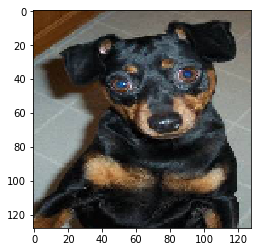

In [9]:
img_filepath = os.path.join(test_dog_img_path, test_dog_img_list[0])
model.predict(img_filepath)

(1, 'dog', 0.94983923)

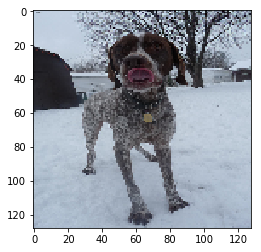

In [10]:
img_filepath = os.path.join(test_dog_img_path, test_dog_img_list[1])
model.predict(img_filepath)

# 3. 배치 데이터 추론
여러분의 개인 랩탑/데스크탑이나 온프레미스에서 수행하는 방법과 동일하게 배치 데이터도 쉽게 추론이 가능합니다. 본 예시에서는 테스트 데이터에 대해서
간단하게 배치 추론을 수행해 보고, 기본적인 평가 지표들인 Confusion Matrix, AUROC(Area Under a ROC Curve), AUPRC(Area Under a Precision-Recall Curve)를 확인해 보겠습니다.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import collections
import json
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_curve, average_precision_score,
                            precision_recall_curve, precision_score, recall_score, f1_score, matthews_corrcoef, auc)
try:
    from joblib import dump, load
except ImportError:
    from sklearn.externals.joblib import dump, load

def plot_roc_curve(y_true, y_score, is_single_fig=False):
    """
    Plot ROC Curve and show AUROC score
    """    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.title('AUROC = {:.4f}'.format(roc_auc))
    plt.plot(fpr, tpr, 'b')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.ylabel('TPR(True Positive Rate)')
    plt.xlabel('FPR(False Positive Rate)')
    if is_single_fig:
        plt.show()
    
def plot_pr_curve(y_true, y_score, is_single_fig=False):
    """
    Plot Precision Recall Curve and show AUPRC score
    """
    prec, rec, thresh = precision_recall_curve(y_true, y_score)
    avg_prec = average_precision_score(y_true, y_score)
    plt.title('AUPRC = {:.4f}'.format(avg_prec))
    plt.step(rec, prec, color='b', alpha=0.2, where='post')
    plt.fill_between(rec, prec, step='post', alpha=0.2, color='b')
    plt.plot(rec, prec, 'b')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    if is_single_fig:
        plt.show()

def plot_conf_mtx(y_true, y_score, thresh=0.5, class_labels=['0','1'], is_single_fig=False):
    """
    Plot Confusion matrix
    """    
    y_pred = np.where(y_score >= thresh, 1, 0)
    print("confusion matrix (cutoff={})".format(thresh))
    print(classification_report(y_true, y_pred, target_names=class_labels))
    conf_mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_mtx, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    if is_single_fig:
        plt.show()

def prob_barplot(y_score, bins=np.arange(0.0, 1.11, 0.1), right=False, filename=None, figsize=(10,4), is_single_fig=False):
    """
    Plot barplot by binning predicted scores ranging from 0 to 1
    """    
    c = pd.cut(y_score, bins, right=right)
    counts = c.value_counts()
    percents = 100. * counts / len(c)
    percents.plot.bar(rot=0, figsize=figsize)
    plt.title('Histogram of score')
    print(percents)
    if filename is not None:
        plt.savefig('{}.png'.format(filename))   
    if is_single_fig:
        plt.show()
    
def evaluate_prediction(y_true, y_score, thresh=0.5):
    """
    All-in-one function for evaluation. 
    """    
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plot_roc_curve(y_true, y_score)
    plt.subplot(1,3,2)    
    plot_pr_curve(y_true, y_score)
    plt.subplot(1,3,3)    
    plot_conf_mtx(y_true, y_score, thresh) 
    plt.show()

def get_score_df(y_true, y_score, start_score=0.0, end_score=0.7, cutoff_interval=0.05):
    """
    Get a dataframe contains general metrics
    """    
    import warnings
    warnings.filterwarnings("ignore")
    score = []
    
    for cutoff in np.arange(start_score, end_score+0.01, cutoff_interval)[1:]:
        y_pred = np.where(y_score >= cutoff, 1, 0)
        conf_mat = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = conf_mat[0,0], conf_mat[0,1], conf_mat[1,0], conf_mat[1,1]
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        if precision !=0 and recall !=0 :
            f1 = f1_score(y_true, y_pred)
        else:
            f1 = 0     
        mcc = matthews_corrcoef(y_true, y_pred)
        score.append([cutoff, tp, fp, tn, fn, precision, recall, f1, mcc])
        
    score_df = pd.DataFrame(score, columns = ['Cutoff', 'TP', 'FP', 'TN' ,'FN', 'Precision', 'Recall', 'F1', 'MCC'])
    return score_df


In [12]:
def get_test_scores(test_img_list, test_img_path):
    num_test = len(test_img_list)
    y_score = np.zeros(num_test)

    for idx, fname in enumerate(test_img_list):
        img_filepath = os.path.join(test_img_path, fname)
        pred_cls, pred_cls_str, pred_score = model.predict(img_filepath, show_image=False)
        y_score[idx] = pred_score    
        
    return y_score

In [13]:
y_dog_score = get_test_scores(test_dog_img_list, test_dog_img_path)
y_dog_true = np.zeros(len(test_dog_img_list)) + 1

y_bg_score = get_test_scores(test_bg_img_list, test_bg_img_path)
y_bg_true = np.zeros(len(test_bg_img_list)) + 0

y_score = np.append(y_dog_score, y_bg_score)
y_true = np.append(y_dog_true, y_bg_true)

confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.57      1.00      0.73         8

   micro avg       0.57      0.57      0.57        14
   macro avg       0.29      0.50      0.36        14
weighted avg       0.33      0.57      0.42        14



/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


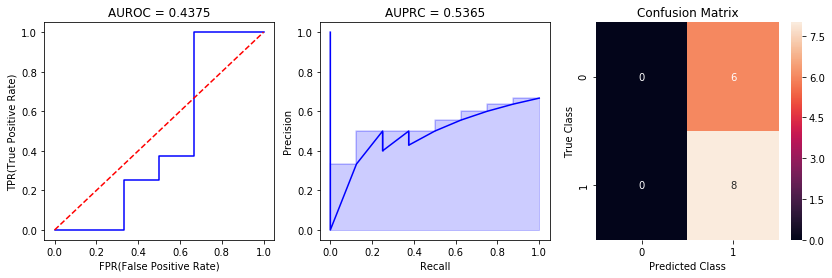

In [14]:
evaluate_prediction(y_true, y_score)